# 10x RNA-seq gene expression data (part 2b)

We can continue to explore our examples looking at the expression of canonical neurotransmitter transporter genes and gene Tac2 over the whole brain. 

You need to be connected to the internet to run this notebook and that you have downloaded the example data via the getting started notebook.

In [1]:
import os
import pandas as pd
import numpy as np
import anndata
import time
from pathlib import Path
import matplotlib.pyplot as plt

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

We will interact with the data using the **AbcProjectCache**. This cache object tracks which data has been downloaded and serves the path to the requsted data on disk. For metadata, the cache can also directly serve a up a Pandas Dataframe. See the ``getting_started`` notebook for more details on using the cache including installing it if it has not already been.

The commented section that calls ``from_local_cache`` can be used instead when a download of the data already exists on disk or running on CodeOcean with the attached Allen Brain Cell Atlas or similar mounting of the AWS s3 bucket as a directory through [s3fs-fuse](https://github.com/s3fs-fuse/s3fs-fuse) or similar.

**Change the download_base variable to where you have downloaded the data in your system.**

In [2]:
download_base = Path('../../abc_download_root')
abc_cache = AbcProjectCache.from_s3_cache(download_base)

# download_base = Path('../../data/abc_atlas') # Path to the already downloaded data or s3fs-fuse mount.
# abc_cache = AbcProjectCache.from_local_cache(download_base)

abc_cache.current_manifest

'releases/20240330/manifest.json'

Read in the expanded cell metadata table from the cache. Examples of creating this table are presented in part 1.

In [3]:
cell = abc_cache.get_metadata_dataframe(directory='WMB-10X', file_name='cell_metadata_with_cluster_annotation')
cell.set_index('cell_label',inplace=True)

cell_metadata_with_cluster_annotation.csv: 100%|██████████| 1.39G/1.39G [00:47<00:00, 29.2MMB/s]   
/Users/chris.morrison/src/miniconda3/envs/abc_atlas_access/lib/python3.11/site-packages/abc_atlas_access/abc_atlas_cache/abc_project_cache.py:398: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(path, **kwargs)


Read in the gene expression dataframe from the cache. How this table was created is presented in part 2a tutorial.

In [4]:
exp = abc_cache.get_metadata_dataframe(directory='WMB-10X', file_name='example_genes_all_cells_expression')
exp.set_index('cell_label',inplace=True)

example_genes_all_cells_expression.csv: 100%|██████████| 318M/318M [00:10<00:00, 30.5MMB/s]    


We define a helper functions *aggregate_by_metadata* to compute the average expression for a given catergory and *plot_umap* to plot cells in a UMAP colorized by metadata or expression values.

In [5]:
def aggregate_by_metadata(df, gnames, value, sort = False):
    grouped = df.groupby(value)[gnames].mean()
    if sort:
        grouped = grouped.sort_values(by=gnames[0], ascending=False)
    return grouped

In [6]:
def plot_umap(xx, yy, cc=None, val=None, fig_width=8, fig_height=8, cmap=None):
    
    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)
    
    if cmap is not None :
        plt.scatter(xx, yy, s=0.5, c=val, marker='.', cmap=cmap)
    elif cc is not None :
        plt.scatter(xx, yy, s=0.5, color=cc, marker='.')
        
    ax.axis('equal')
    ax.set_xlim(-18, 27)
    ax.set_ylim(-18, 27)
    ax.set_xticks([])
    ax.set_yticks([])
    
    return fig, ax

### Expression of canonical neurotransmitter transporter genes in the whole brain

During analysis, clusters were assigned neurotransmitter identities based on the expression of of canonical neurotransmitter transporter genes. In this example, we create a dataframe comprising of expression of the 9 solute carrier family genes for all the cells in the dataset.  We then group the cells by the assigned neurotransmitter class and compute the mean expression for each group. We define a simple helper function to visualized the expression as a heatmap.

In [7]:
def plot_heatmap(df, fig_width=8, fig_height=4, cmap=plt.cm.magma_r):

    arr = df.to_numpy()

    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)

    im = ax.imshow(arr, cmap=cmap, aspect='auto', vmin=0, vmax=6)
    xlabs = df.columns.values
    ylabs = df.index.values

    ax.set_xticks(range(len(xlabs)))
    ax.set_xticklabels(xlabs)

    ax.set_yticks(range(len(ylabs)))
    res = ax.set_yticklabels(ylabs)
    
    return im

In [8]:
ntgenes = ['Slc17a7', 'Slc17a6', 'Slc17a8', 'Slc32a1', 'Slc6a5', 'Slc18a3', 'Slc6a3', 'Slc6a4', 'Slc6a2']
filtered = exp[ntgenes]
joined = cell.join(filtered)

The results are similar that in part 1. Using data from the whole brain, gene Slc17a7 is now most enriched in glutamatergic assigned cells with some expression in cholinergic types. Gene Slc17a6 is most enriched in noradrenergic, then cholinergic types. Genes Slc6a5, Slc18a3, Slc6a3, Slc6a4 and Slc6a2 shows high specificity to glycinergic, cholinergic, dopaminergic, serotonergic and noradrenergic respectively.

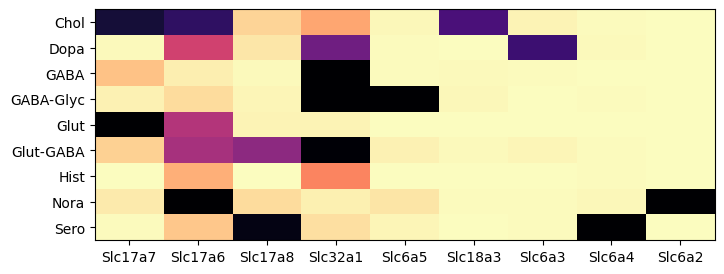

In [9]:
agg = aggregate_by_metadata(joined, ntgenes, 'neurotransmitter')
agg = agg[ntgenes]
res = plot_heatmap(agg, 8, 3)

We can also visualize the relationship between transport genes and neurotransmitter identities on the UMAP.

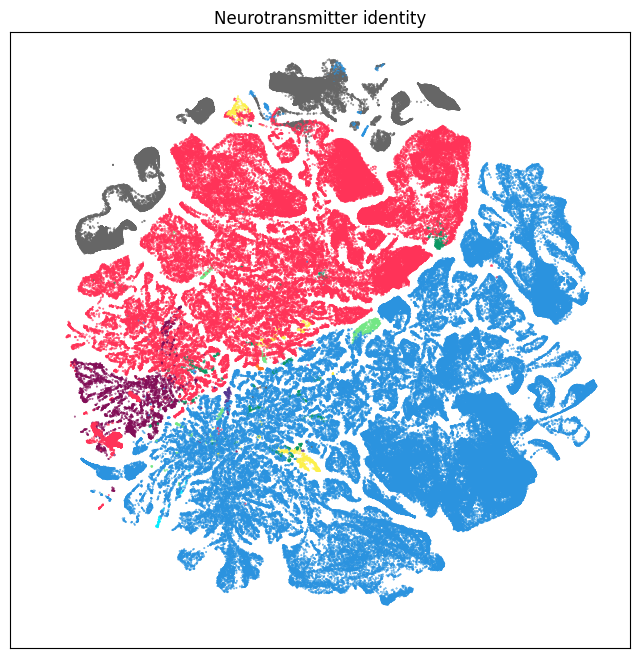

In [10]:
subsampled = joined.loc[::10]
fig, ax = plot_umap(subsampled['x'], subsampled['y'], cc=subsampled['neurotransmitter_color'])
res = ax.set_title("Neurotransmitter identity")

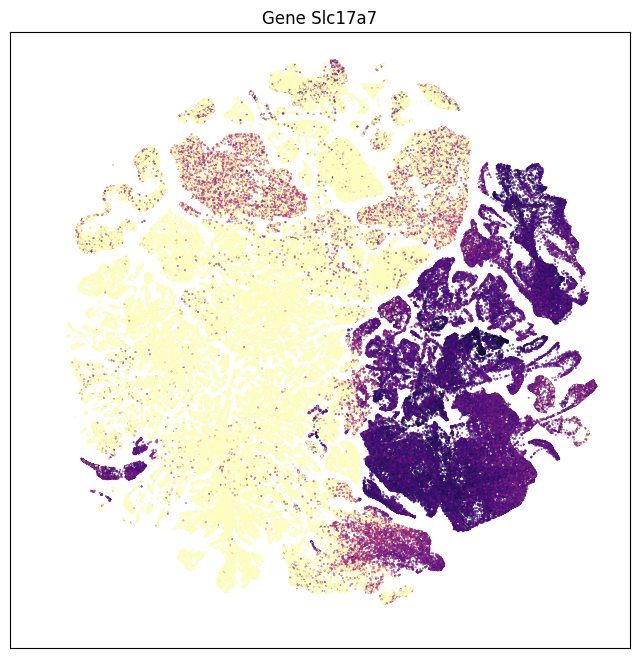

In [11]:
fig, ax = plot_umap(subsampled['x'], subsampled['y'], val=subsampled['Slc17a7'], cmap=plt.cm.magma_r)
res = ax.set_title("Gene Slc17a7")

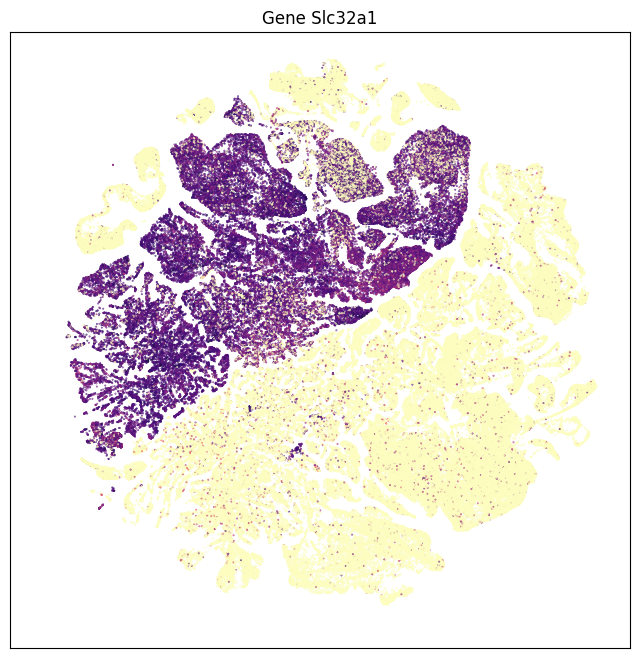

In [12]:
fig, ax = plot_umap(subsampled['x'], subsampled['y'], val=subsampled['Slc32a1'], cmap=plt.cm.magma_r)
res = ax.set_title("Gene Slc32a1")

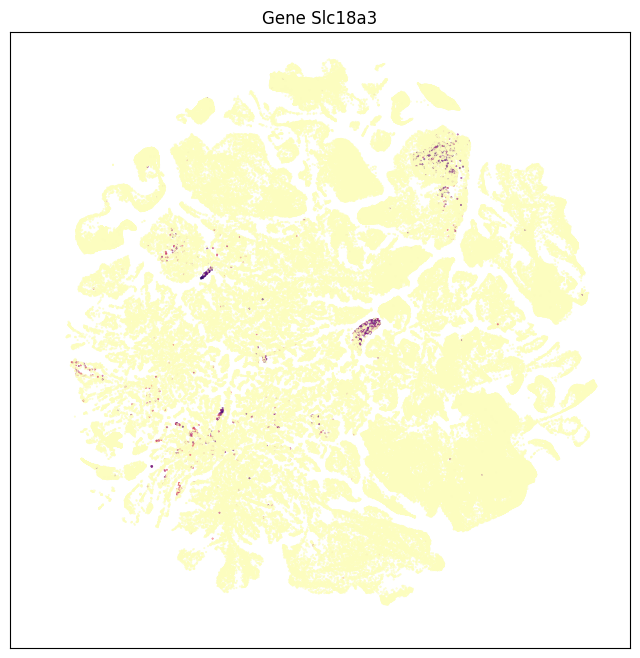

In [13]:
fig, ax = plot_umap(subsampled['x'], subsampled['y'], val=subsampled['Slc18a3'], cmap=plt.cm.magma_r)
res = ax.set_title("Gene Slc18a3")

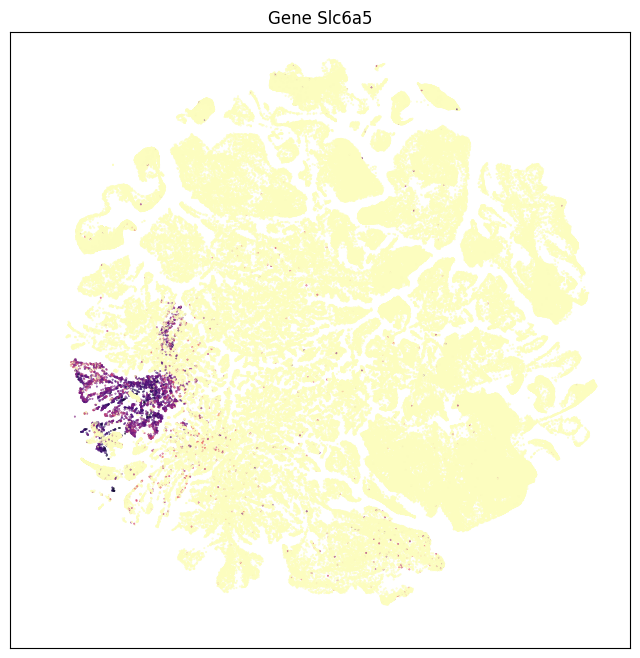

In [14]:
fig, ax = plot_umap(subsampled['x'], subsampled['y'], val=subsampled['Slc6a5'], cmap=plt.cm.magma_r)
res = ax.set_title("Gene Slc6a5")

Grouping expression by dissection region of interest shows that each of these genes have distinct spatial patterns. Genes Slc17a7 is enriched in the cortex, Slc32a1 in the striatum, Slc17a6 in the thalamus, Slc6a3 in the midbrain, and Slc6a5 in the medulla. 

In [15]:
roi = abc_cache.get_metadata_dataframe(directory='WMB-10X', file_name='region_of_interest_metadata')
roi.set_index('acronym', inplace=True)

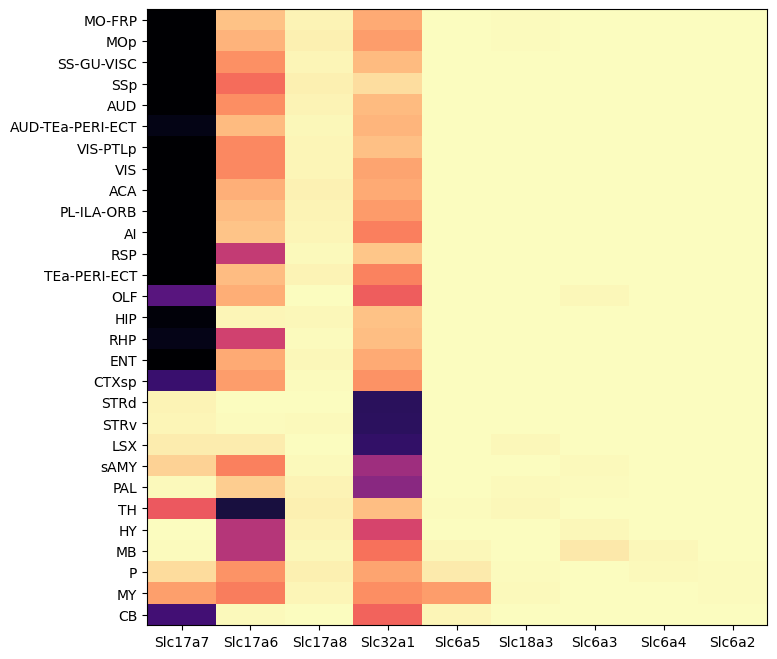

In [16]:
agg = aggregate_by_metadata(joined, ntgenes, 'region_of_interest_acronym')
agg = agg.loc[roi.index] # order roi by anatomical order
res = plot_heatmap(agg, 8, 8)

### Expression of Tachykinin 2 (Tac2) in the whole brain

In mice, the tachykinin 2 (Tac2) gene encodes neuropeptide called neurokinin B (NkB). Tac2 is produced by neurons in specific regions of the brain know to be invovled in emotion and social behavior. Based on [ISH data](https://mouse.brain-map.org/experiment/siv?id=77279001&imageId=77284584&initImage=ish&coordSystem=pixel&x=5384.5&y=3832.5&z=3) from the Allen Mouse Brain Atlas, Tac 2 is sparsely expressed in the mouse isocortex and densely enriched is specific subcortical regions such the medial habenula (MH), the amygdala and hypothalamus.

In this example, we create a dataframe comprising expression values of Tac2 for all cells across the whole brain. As with the thalamus only example, grouping expression by neurotransmitter show that Tac2 gene is highly enriched in cholinergic cell types. With the rest of brain included, we can observe that Tac2 is also enriched in Glut-GABA cell types as well.

In [17]:
exgenes = ['Tac2']
filtered = exp[exgenes]
joined = cell.join(filtered)
subsampled = joined.loc[::10]

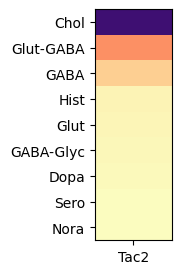

In [18]:
agg = aggregate_by_metadata(joined, exgenes, 'neurotransmitter', True)
plot_heatmap(agg, 1, 3)

Grouping by class, shows that Tac2 is enriched in class "16 MH-LH Glut" with cells restricted to the medial (MH) and lateral (LH) habenula and a mixture of glutamatergic and cholinergic type and "06 CTX-CGE GABA" GABAergic cells originating from the caudal ganglionic eminence (CGE).

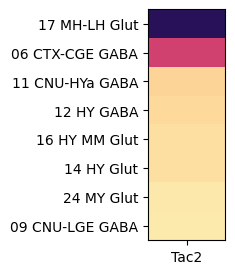

In [19]:
agg = aggregate_by_metadata(joined, exgenes, 'class', True).head(8)
plot_heatmap(agg, 1, 3)

At the next level, grouping by subclass reveals enrichment is highly anatomically localized cell types such as the medial habenula (MH), bed nuclei of the stria terminalis (BST), spinal nucleus of the trigeminal (SPVC), main olfactory blub (MOB), central amygdalar nucleus (CEA) and arcuate hypothalamic nucleus (ARH).

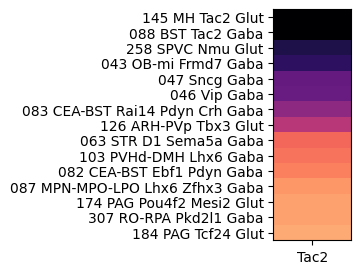

In [20]:
agg = aggregate_by_metadata(joined, exgenes, 'subclass', True).head(15)
subclass_list = agg.index[0:10]
plot_heatmap(agg, 1, 3)

Plotting Tac2 expression on the UMAP enables you see whole brain expression in one view showing Tac2 expression is highly restricted to a small number of clusters. Further we can compare the expression profile with the top 10 enriched subclasses.

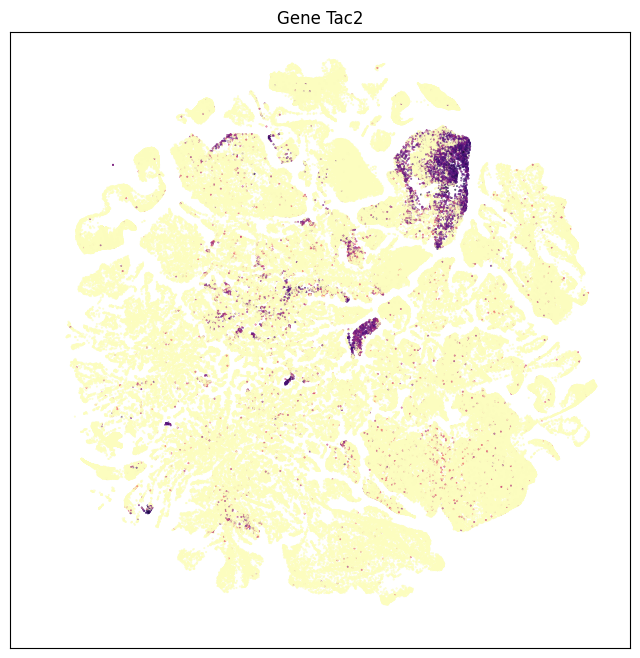

In [21]:
fig, ax = plot_umap(subsampled['x'], subsampled['y'], val=subsampled['Tac2'], cmap=plt.cm.magma_r)
res = ax.set_title("Gene Tac2")

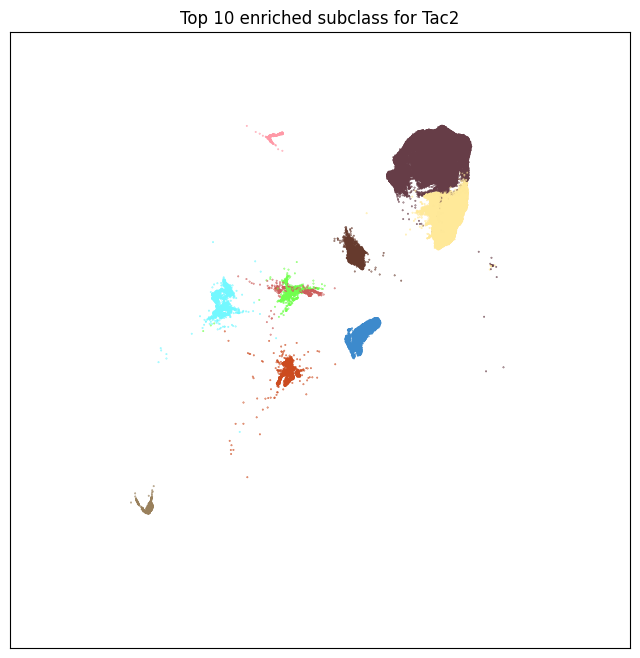

In [22]:
pred = [x in subclass_list for x in joined['subclass']]
filtered = joined[pred]

fig, ax = plot_umap(filtered['x'], filtered['y'], cc=filtered['subclass_color'])
res = ax.set_title("Top 10 enriched subclass for Tac2")